In [1]:
#インポート関連一式
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import warnings
from sklearn import linear_model
warnings.simplefilter("ignore")

In [2]:
#データクレンジング後のcsv(./comp_files/~~.csv)を順次読み込む

#関数
def select_league(league): # 0: セ・リーグ 1: パ・リーグ
    if league == 0:
        fname_p = f"./comp_files/{year_list[i]}_clg_Pitchers.csv"
        fname_f = f"./comp_files/{year_list[i]}_clg_Fielders.csv"
        return fname_p, fname_f
    elif league == 1:
        fname_p = f"./comp_files/{year_list[i]}_plg_Pitchers.csv"
        fname_f = f"./comp_files/{year_list[i]}_plg_Fielders.csv"
        return fname_p, fname_f
    else:
        print("0 or 1を入力")

#--------------------------------------------------------------------------------------------------------
#main処理
#--------------------------------------------------------------------------------------------------------
#投手用
# col = re_df.columns #Index(['選手名', '球速', 'コントロール', 'スタミナ', '球団', '背番号']
year_list = ["2011", "2012", "2013", "2014", "2016", "2018", "2020", "2022"]
num = len(year_list)
numbering_list_p = []
#リーグ選択  0: セ・リーグ 1: パ・リーグ
league = 0

#year_list分データを読み込み、結合する
for i in range(num):
    fname = select_league(league)
    base_p_df = pd.read_csv(fname[0], encoding="utf-8") #fname[0] 投手 fname[1] 野手
    status = base_p_df.iloc[:,:5]
    team = base_p_df.iloc[:,-2:-1]
    re_p_df = pd.concat([status, team], axis=1)
    re_p_df["ナンバリング"] = year_list[i]
    numbering_list_p.append(re_p_df)
#ナンバリング分のDFを結合
re_p_df = pd.concat(numbering_list_p, ignore_index = True, axis=0)
all_p_df = re_p_df.groupby(["球団","ナンバリング"], as_index=False).mean()
#結合したDFをソート
sort_p_df = all_p_df.sort_values(["ナンバリング", "球団"])
sort_p_df

#野手用
numbering_list_f = []
for i in range(num):
    fname = select_league(league)
    base_f_df = pd.read_csv(fname[1], encoding="utf-8")
    re_f_df = base_f_df.drop("背番号", axis=1)
    re_f_df["ナンバリング"] = year_list[i]
    numbering_list_f.append(re_f_df)
#ナンバリング分のDFを結合
re_f_df = pd.concat(numbering_list_f, ignore_index = True, axis=0)
all_f_df = re_f_df.groupby(["球団","ナンバリング"], as_index=False).mean()
#結合したDFをソート
sort_f_df = all_f_df.sort_values(["ナンバリング", "球団"])
sort_f_df = sort_f_df.drop(["球団", "ナンバリング"], axis=1)
#インデックスでmerge 0 7 14 21 28 indexはmerge後に振りなおす
convert_df = pd.merge(sort_p_df, sort_f_df, how="inner", left_index=True, right_index=True)
convert_df.reset_index(drop=True, inplace=True)
#実際の勝率をエクセルから取得する
base_df = pd.read_excel("2023_baseball.xlsx")
base_df.rename(columns={2009: "球団"}, inplace=True)
#ナンバリングと同じ年数を抽出
rd2011 = base_df[16:22].sort_values("球団") #2011
rd2012 = base_df[24:30].sort_values("球団") #2012
rd2013 = base_df[32:38].sort_values("球団") #2013
rd2014 = base_df[40:46].sort_values("球団") #2014
rd2016 = base_df[56:62].sort_values("球団") #2016
rd2018 = base_df[72:78].sort_values("球団") #2018
rd2020 = base_df[88:94].sort_values("球団") #2020
rd2022 = base_df[104:110].sort_values("球団") #2022
#concatで結合
ex_lis = [rd2011, rd2012, rd2013, rd2014, rd2016, rd2018, rd2020, rd2022]
ex_df = pd.concat(ex_lis, ignore_index=True, axis=0)
ex_col = ex_df.columns  #Index(['球団', '勝率', '勝', '敗', '分', '得点', '失点', '打率', '本塁打', '盗塁', '防御率']
#convert_dfに勝率を追加　行数は同じためそのまま代入
convert_df["勝率"] = ex_df["勝率"]
convert_df["順位"] = ex_df["順位"]
#各年代の各チームでの平均値のcsvを保存する　機械学習、分析用など
if league == 0:
    convert_df.to_csv("DL_PawaClg.csv", encoding="utf-8", index=False)
else:
    convert_df.to_csv("DL_PawaPlg.csv", encoding="utf-8", index=False)
#外れ値を指定　インデックスを取得
rows = convert_df.loc[[9,15,21,33,28]]
fordrop = convert_df.index[rows.index]
#インデックスのリスト指定でドロップ
convert_df2 = convert_df.drop(fordrop, axis=0)
#2020までのステータスのみ抽出(予測モデルデータ)
status = convert_df2.iloc[:37, 2:13]
#2020までの勝率のみ(予測モデルデータ)
y = convert_df2.iloc[0:37, 13:14]

回帰係数: [-0.00605473 -0.00163024 -0.00037429  0.12182311  0.06546387 -0.0011336
  0.00368517 -0.01679918 -0.00491838  0.00126129  0.0013455 ]
切片: 1.7455388409265178
決定係数: 0.6179700963167437


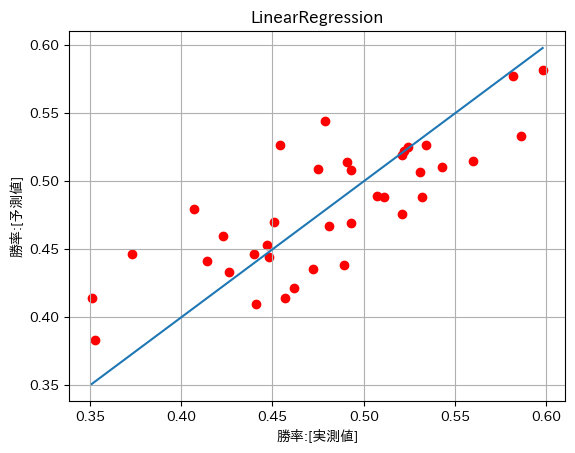

In [3]:
#予測モデル作成 LinearRegression
model = linear_model.LinearRegression()
model.fit(status,y)
#決定係数などを出力
print("回帰係数:", model.coef_[0])
print("切片:", model.intercept_[0]) # 切片を出力
print("決定係数:", model.score(status,y))
#予測
predict = model.predict(status)
#次元が(36,1)になっているため、転置して(36,)に変更する ndarrayに変換後、転置
y_np = np.array(y)
yt = y_np.T
predict_np = np.array(predict)
predict_t = predict_np.T

#グラフを描画　勝率[実測値,予測値]で散布図
plt.scatter(y, predict, color="r")
plt.plot(np.linspace(min(yt[0]),max(yt[0])), np.linspace(min(yt[0]),max(yt[0])))
plt.title("LinearRegression")
plt.xlabel("勝率:[実測値]")
plt.ylabel("勝率:[予測値]")
plt.grid()
plt.show()

In [4]:
#作成したモデルで順位予想
#2022のステータスを用意
status2022 = convert_df2.iloc[37:, 2:13] #行:2020まで　列:勝率前まで
y2022 = convert_df2.iloc[37:, 13:] #2020までの勝率のみ
predict = model.predict(status2022)
result = convert_df.iloc[42:,:2] #元のDFからインデックス　ナンバリングを再利用
result["LR予想勝率"] = predict

#結果表示
rank_list = [1,2,3,4,5,6]
rank = result.sort_values("LR予想勝率", ascending=False).round(4)
rank.rename(columns={"ナンバリング": "年度"}, inplace=True)
rank["予想順位"] = rank_list
# display(rank)
rank.to_csv("Predict_LinearRegression.csv", encoding="utf-8", index=False)
rank.to_csv("Predict_LinearRegression_forWindows.csv", encoding="cp932", index=False)
print("勝率予想by LinearRegression")
for i in range(6):
    print("-------------------------------")
    print(f"{rank_list[i]}位: {rank.values[i][0]}:{rank.values[i][2]:.2%}")
print("-------------------------------")

勝率予想by LinearRegression
-------------------------------
1位: 中日:62.19%
-------------------------------
2位: 巨人:59.44%
-------------------------------
3位: DeNA:53.17%
-------------------------------
4位: 広島:51.70%
-------------------------------
5位: ヤクルト:48.15%
-------------------------------
6位: 阪神:47.15%
-------------------------------
